<a id="toc"></a>
# HERMES beamline simulation with SRW
***

Contents :
1. [Photon source definition](#def_source)
1. [Beamline definition](#def_bl)
1. [Wavefront propagation](#wft_prog)
1. [Visualisation](#visu)

In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '01/AUG/2024'
__changed__ = '06/AUG/2024'

import numpy as np
import oasys_srw.srwlib as srwlib 
from barc4sr.aux_utils import ElectronBeam, MagneticStructure
from barc4xoc.aux_srw import wavefront_info, get_rays_from_wavefront, srw_quick_plot, orient_mirror
from scipy.constants import c, degree, eV, h, micro, milli, nano, pi, pico
from copy import deepcopy

%matplotlib notebook    
%load_ext autoreload
%autoreload 2

<a id="def_source"></a>
## Photon source definition
[Back to the top](#toc)

### Initial wavefront

In [2]:
ini_wft_npix = [100, 100]
ini_wft_range = [5e-3, 5e-3]
beam_energy = 719.9
pupil_position = 18.151
sampling_factor = 0.2

In [3]:
mesh = srwlib.SRWLRadMesh(_eStart=beam_energy,
                          _eFin  =beam_energy,
                          _ne    =1,
                          _xStart= -ini_wft_range[0]/2,
                          _xFin  = ini_wft_range[0]/2,
                          _nx    = ini_wft_npix[0],
                          _yStart= -ini_wft_range[1]/2,
                          _yFin  = ini_wft_range[1]/2,
                          _ny    = ini_wft_npix[1],
                          _zStart=pupil_position)

wfr = srwlib.SRWLWfr()
wfr.allocate(mesh.ne, mesh.nx, mesh.ny)
wfr.unitElFld = 1
wfr.mesh = mesh

### Electron beam

In [4]:
straight_section = ElectronBeam()
straight_section.from_twiss(energy=2.75, energy_spread=0.1025/100, current=0.500,
                  emittance=3.94*nano, coupling=1/100,
                  beta_x=4.7890, eta_x= 0.1804, etap_x= 0.0007, alpha_x=-0.3858,
                  beta_y=3.7497, eta_y=-0.0044, etap_y=-0.0025, alpha_y=-0.7746)

In [5]:
print('> Generating the electron beam ... ', end='')

e_beam = srwlib.SRWLPartBeam()
e_beam.Iavg = straight_section.current

e_beam.partStatMom1.x = 0.0
e_beam.partStatMom1.y = 0.0
e_beam.partStatMom1.z = 0.0 
e_beam.partStatMom1.xp = 0.0
e_beam.partStatMom1.yp = 0.0
e_beam.partStatMom1.gamma = straight_section.get_gamma()

e_beam.arStatMom2[0] = straight_section.moment_xx          # <(x-<x>)^2>
e_beam.arStatMom2[1] = straight_section.moment_xxp         # <(x-<x>)(x'-<x'>)>
e_beam.arStatMom2[2] = straight_section.moment_xpxp        # <(x'-<x'>)^2>
e_beam.arStatMom2[3] = straight_section.moment_yy          # <(y-<y>)^2>
e_beam.arStatMom2[4] = straight_section.moment_yyp         # <(y-<y>)(y'-<y'>)>
e_beam.arStatMom2[5] = straight_section.moment_ypyp        # <(y'-<y'>)^2>
e_beam.arStatMom2[10] = straight_section.energy_spread**2  # <(E-<E>)^2>/<E>^2

wfr.partBeam = e_beam
print('completed')

> Generating the electron beam ... completed


### Undulator

In [6]:
u64 = MagneticStructure(K_vertical=0.0,
                        K_horizontal=0.0,
                        period_length=64e-3,
                        number_of_periods=28.0)

u64.set_resonant_energy(beam_energy, 1, straight_section.energy_in_GeV, "v")


In [7]:
print('> Generating the magnetic structure ... ', end='')
# Electron trajectory
eTraj = 0
e_beam.partStatMom1.z = -0.5*u64.period_length*(u64.number_of_periods + 4)   # initial Longitudinal Coordinate (set before the ID)

und = srwlib.SRWLMagFldU()
und.set_sin(_per=u64.period_length,
            _len=u64.period_length*u64.number_of_periods, 
            _bx=u64.B_horizontal, 
            _by=u64.B_vertical, 
            _phx=0, _phy=0, _sx=-1, _sy=-1)
magFldCnt = srwlib.SRWLMagFldC(_arMagFld=[und],
                                _arXc=srwlib.array('d', [0.0]),
                                _arYc=srwlib.array('d', [0.0]),
                                _arZc=srwlib.array('d', [0.0]))
print('completed')

> Generating the magnetic structure ... completed


### Generation of initial wavefront

In [8]:
arPrecSR = [0]*7
arPrecSR[0] = 1     # SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
arPrecSR[1] = 0.01  # relative precision
arPrecSR[2] = 0     # longitudinal position to start integration (effective if < zEndInteg)
arPrecSR[3] = 0     # longitudinal position to finish integration (effective if > zStartInteg)
arPrecSR[4] = 50000 # Number of points for trajectory calculation
arPrecSR[5] = 1     # Use "terminating terms"  or not (1 or 0 respectively)
arPrecSR[6] = sampling_factor # sampling factor for adjusting nx, ny (effective if > 0)

In [9]:
print('>  Undulator initial electric field calculation ... ', end='')
srwlib.srwl.CalcElecFieldSR(wfr, eTraj, magFldCnt, arPrecSR)
print('completed')

wavefront_info(wfr)

>  Undulator initial electric field calculation ... completed

Wavefront information:
Nx = 196, Ny = 196
dx = 25.6410 um, dy = 25.6410 um
range x = 5.0000 mm, range y = 5.0000 mm
Rx = 18.13542465 m, Ry = 18.13542465 m


In [10]:
# srw_quick_plot(wfr)

<a id="def_bl"></a>
## Beamline definition

[Back to the top](#toc)

### Pupil
[Back to the top](#toc)

In [11]:
pupil = srwlib.SRWLOptA(_shape='r', _ap_or_ob='a', _Dx=ini_wft_range[0], _Dy=ini_wft_range[0])
pp_pupil = [0, 0, 1.0, 1, 0, 1., 5., 1., 5., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### M1
[Back to the top](#toc)

#### M1A

In [12]:
orientation = orient_mirror(incident_angle=2.5*degree, orientation='right')

m1a = srwlib.SRWLOptMirPl(_size_tang=200e-3, _size_sag=18e-3, _npt=100, _nps=100,
                         _nvx=orientation['nvx'], _nvy=orientation['nvy'], _nvz=orientation['nvz'], 
                         _tvx=orientation['tvx'], _tvy=orientation['tvy'])

pp_m1a = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### drift

In [13]:
d2m1b = srwlib.SRWLOptD(0.470422)
pp_d2m1b = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### M1B

In [14]:
orientation = orient_mirror(incident_angle=2.5*degree, orientation='left')

m1b = srwlib.SRWLOptMirTor(_rt=126.7433,_rs=1.802572,_size_tang=200e-3, _size_sag=10e-3, _npt=1001, _nps=1001,
                          _nvx=orientation['nvx'], _nvy=orientation['nvy'], _nvz=orientation['nvz'], 
                          _tvx=orientation['tvx'], _tvy=orientation['tvy'])
pp_m1b = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### drift

In [15]:
d2S1 = srwlib.SRWLOptD(3.2095982206327456)
pp_d2S1 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Monochromator
[Back to the top](#toc)

#### Mono entrance slit

In [16]:
S1 = srwlib.SRWLOptA(_shape='r', _ap_or_ob='a', _Dx=ini_wft_range[0], _Dy=ini_wft_range[0])
pp_S1 = [0, 0, 1.0, 0, 0, 2/3, 3/2., 1, 4., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# pp_S1 = [0, 0, 1.0, 0, 0, 1., 2., 1, 2., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### drift

In [17]:
d2G = srwlib.SRWLOptD(0.6)
pp_d2G = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### Grating 450 l/mm

TODO: referify against example 12

In [18]:
grazG = 2.302402*degree
outG = 0.460361*degree

deflection = (grazG+outG)*(1+0.840e-4)

# oe_array.append(srwlib.SRWLOptA('r', 'a', 5e-3, np.sin(grazG)*80e-3))
# pp_array.append([0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

orientation = orient_mirror(incident_angle=grazG, orientation='up', invert_tangential_component=False)
substrate = srwlib.SRWLOptMirPl(_size_tang=80e-3, _size_sag=5e-3, _npt=5001, _nps=5001,
                                _nvx=orientation['nvx'], _nvy=orientation['nvy'], _nvz=orientation['nvz'], 
                                _tvx=orientation['tvx'], _tvy=orientation['tvy'])

vls = [450.00015185438964, -4.9135366794975125, -18.437531686217524, 4.9580003419891]
G450 = srwlib.SRWLOptG(_mirSub=substrate, _m=-1, _grDen=vls[0], _grDen1=vls[1]*0, _grDen2=vls[2]*0, _grDen3=vls[3]*0, _cff=0.2, _ang_graz=grazG)

pp_G450 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, np.sin(2*deflection), np.cos(2*deflection), 1, 0]


#### drift

In [19]:
d2m2 = srwlib.SRWLOptD(0.311199)
pp_d2m2 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### M2

In [20]:
orientation = orient_mirror(incident_angle=0.5*deflection, orientation='down')

m2 = srwlib.SRWLOptMirPl(_size_tang=120e-3, _size_sag=15e-3, _npt=500, _nps=500,
                         _nvx=orientation['nvx'], _nvy=orientation['nvy'], _nvz=orientation['nvz'], 
                         _tvx=orientation['tvx'], _tvy=orientation['tvy'])

pp_m2 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### drift

In [21]:
d2m3 = srwlib.SRWLOptD(0.239162)
pp_d2m3 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### M3

In [22]:
orientation = orient_mirror(incident_angle=1.2*degree, orientation='left')

m3 = srwlib.SRWLOptMirTor(_rt=83.0,_rs=0.1462124,_size_tang=120e-3, _size_sag=10e-3, _npt=1001, _nps=1001,
                          _nvx=orientation['nvx'], _nvy=orientation['nvy'], _nvz=orientation['nvz'], 
                          _tvx=orientation['tvx'], _tvy=orientation['tvy'])

pp_m3 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### drift

In [23]:
d2S2 = srwlib.SRWLOptD(3.5)
pp_d2S2 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### Mono exit slit

In [24]:
S2 = srwlib.SRWLOptA(_shape='r', _ap_or_ob='a', _Dx=ini_wft_range[0], _Dy=ini_wft_range[0])
pp_S2 = [0, 0, 1.0, 0, 0, 1., 1., 1, 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# pp_S2 = [0, 0, 1.0, 0, 0, 1/2, 2., 1/8, 8., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### STXM branch
[Back to the top](#toc)

#### drift

In [25]:
d2m4 = srwlib.SRWLOptD(2)
pp_d2m4 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### M4

In [26]:
orientation = orient_mirror(incident_angle=1.35*degree, orientation='right')

m4 = srwlib.SRWLOptMirTor(_rt=79.0,_rs=0.0396,_size_tang=70e-3, _size_sag=4e-3, _npt=1001, _nps=1001,
                          _nvx=orientation['nvx'], _nvy=orientation['nvy'], _nvz=orientation['nvz'], 
                          _tvx=orientation['tvx'], _tvy=orientation['tvy'])
pp_m4 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


#### drift to virtual source

In [27]:
d2vs = srwlib.SRWLOptD(2)
pp_d2vs = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### ZP illumination

In [28]:
d2zp = srwlib.SRWLOptD(3.5)
pp_d2zp = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### PEEM branch
[Back to the top](#toc)

#### drift

In [29]:
d2m5 = srwlib.SRWLOptD(1.0)
pp_d2m5 = [0, 0, 1.0, 1, 0, 1., 1., 1., 1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### M5

<a id="wft_prog"></a>
## Wavefront propagation

[Back to the top](#toc)

In [30]:
# pp_array.append([0, 0, 1.0, 0, 0, 1., 1., 0.2, 5., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [31]:
OE = [pupil,    m1a,    d2m1b,    m1b,    d2S1,    S1,    d2G,    G450,    d2m2,    m2,    d2m3,    m3,    d2S2,    S2]
PP = [pp_pupil, pp_m1a, pp_d2m1b, pp_m1b, pp_d2S1, pp_S1, pp_d2G, pp_G450, pp_d2m2, pp_m2, pp_d2m3, pp_m3, pp_d2S2, pp_S2]

branch = "stxm"

oe_branch = []
pp_branch = []

if branch.lower() == "stxm":
    oe_branch =    [d2m4, m4,    d2vs,    d2zp]
    pp_branch = [pp_d2m4, pp_m4, pp_d2vs, pp_d2zp]
    print("STXM")
elif branch.lower() == "peem":
    oe_branch =    [d2m5]
    pp_branch = [pp_d2m5]
    print("PEEM")
else:
    print("Mono exit slit")
    oe_branch = [srwlib.SRWLOptL(_Fx=-0.46126831, _Fy=-0.02368626)]
    pp_branch = [[0, 0, 1.0, 0, 0, 0.5, 2., 0.1, 10., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

for oe, pp in zip(oe_branch, pp_branch):
    OE.append(oe)
    PP.append(pp)
    
optBL = srwlib.SRWLOptC(OE, PP)
print('> Simulating electric field propagation ... ', end='')
pwfr = deepcopy(wfr)
srwlib.srwl.PropagElecField(pwfr, optBL)
print('completed')
wavefront_info(pwfr)


STXM
> Simulating electric field propagation ... completed

Wavefront information:
Nx = 980, Ny = 3920
dx = 2.0501 um, dy = 2.2221 um
range x = 2.0070 mm, range y = 8.7085 mm
Rx = 3.14527086 m, Ry = 4.03778633 m


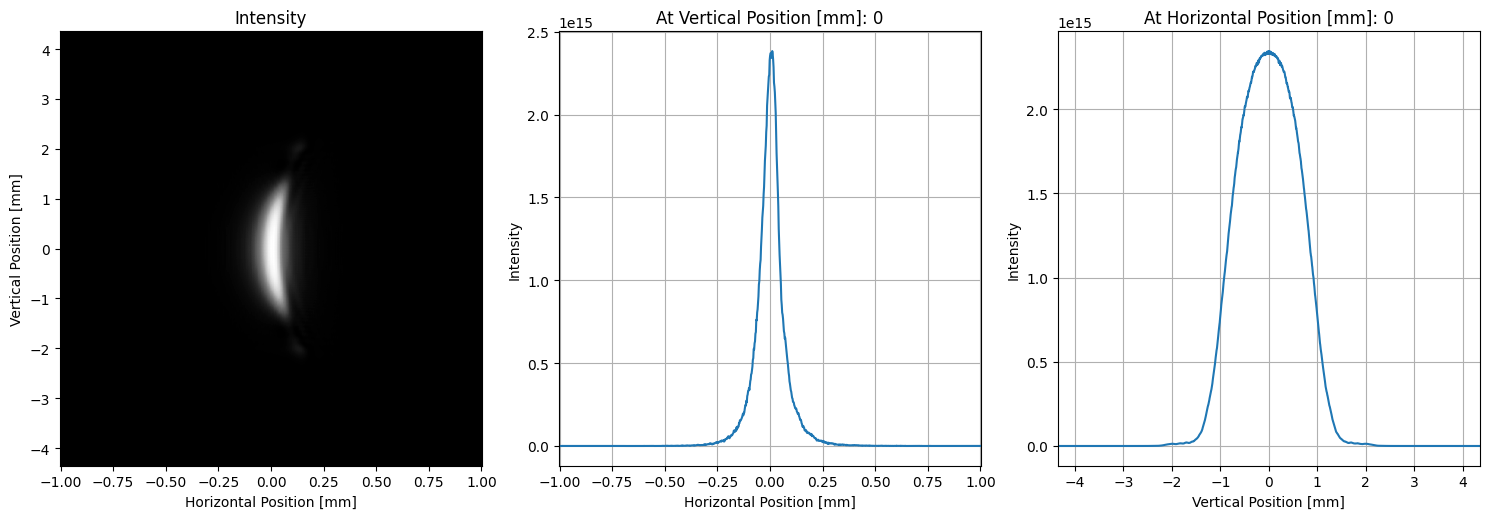

In [32]:
srw_quick_plot(pwfr, me=0, phase=False)

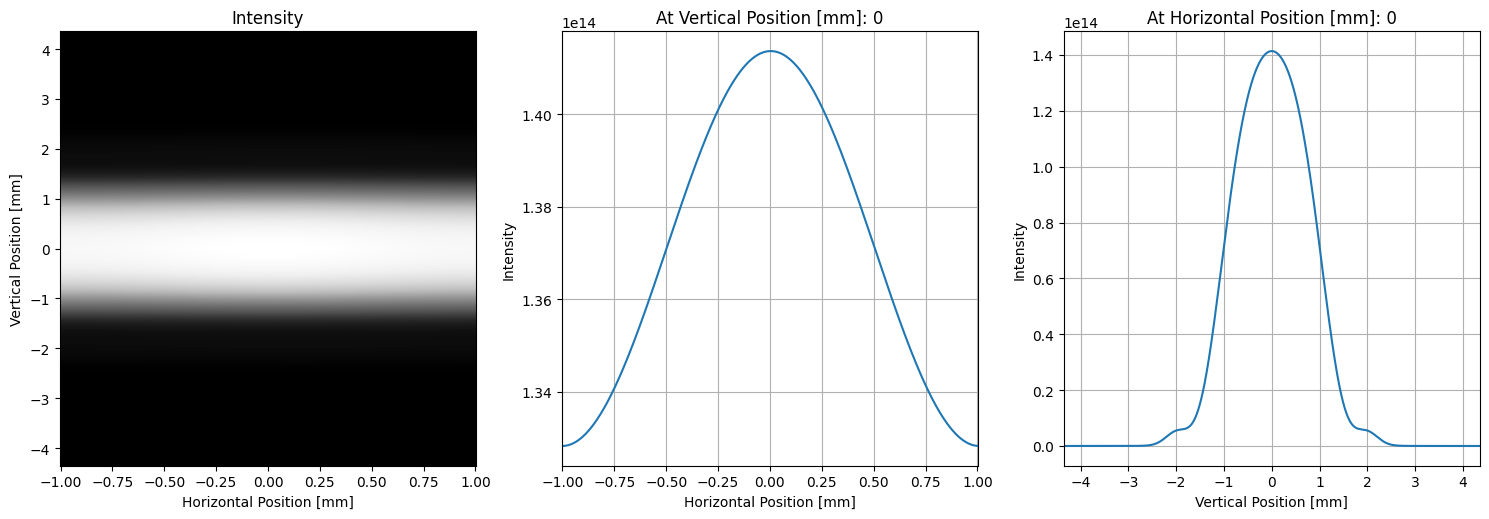

In [33]:
srw_quick_plot(pwfr, me=1, phase=False)

# SRW propagation parameters reference:

```Python
#[ 0]: Auto-Resize (1) or not (0) Before propagation
#[ 1]: Auto-Resize (1) or not (0) After propagation
#[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[ 3]: Type of free-space propagator:
#        0- Standard Fresnel
#        1- Fresnel with analytical treatment of the quadratic (leading) phase terms
#        2- Similar to 1, yet with different processing near a waist
#        3- For propagation from a waist over a ~large distance
#        4- For propagation over some distance to a waist
#        5- Huygens-Fresnel diffraction integral
#[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[ 6]: Horizontal Resolution modification factor at Resizing
#[ 7]: Vertical Range modification factor at Resizing
#[ 8]: Vertical Resolution modification factor at Resizing
#[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
#[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
#[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
#[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
#[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
```